# 基于ResNet的风格迁移

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)]()&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)]()&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)]()

## 风格迁移

风格迁移（style transfer)主要是通过深度神经网络，将一副艺术风格画（style image)的风格融合到内容图像(content image)，生成一幅既保持内容图像原始内容，又保持风格图像特有风格的新图像。2015年，Gatys等人发表了文章[《A Neural Algorithm of Artistic Style》](https://arxiv.org/abs/1508.06576)，首次使用深度学习进行艺术画风格学习。

在本案例中，将了解到风格迁移的基本步骤，以及如何使用MindSpore去实现它。

### 卷积神经网络的特征提取

一个深度卷积神经网络（CNN）中有很多卷积层，每一个卷积层都是在上一层的Feature Map的基础上进行一次特征提取，随着深度的增加，图像会变得更抽象，更接近本质。因此通常认为，越接近输入层的Feature Map，包含更多纹理信息，在分割中常称为低级语义特征;而越靠近输出层的Feature Map，会包含更多内容信息。从另一个角度理解，在数据处理的过程中，随着网络层数的加深，图像经过的处理变多，每次处理的信息量会变少。最初的原始图片包含了所有信息，每次对图片进行操作之后，无论进行何种操作，其所包含的信息一定小于或等于原图片包含的信息。也就是说，网络深层的Feature Map的信息是不会大于其前层的信息的，因此前层的Feature Map保留了更多细节。此外，在图像识别任务中，反向传播是根据标签计算损失梯度，从网络深层向浅层更新，因此越深层的网络会包含更多图像本质（标签）的信息，即内容信息。

### 风格迁移的原理

我们使用卷积神经网络分别提取风格图像的浅层信息以及内容图像的深层信息，以及生成新画作的网络模型，这三个网络可以使用相同的卷积神经网络，如VGG，ResNet等，本案例使用了ResNet18。同时，我们要分别定义风格损失函数和内容损失函数。内容损失函数用于表示新图像与内容图像之间的内容差异，因此我们采用深层（`layer3`)的Featrue Map作为内容信息的展示，则有：

$$
L_{content}(\vec p, \vec x, l) = \frac{1}{2}\sum_{i.j}(F_{i,j}^l-P_{i,j}^l)^2
$$

其中，$L_{content}$表示内容损失，$\vec p$是内容图像的特征向量，$\vec x$是新图像的特征向量， $l$表示网络层数。$F_{i,j}$表示新图像经过第$l$层后的Feature Map第$i$个通道的第$j$个像素点的值，$P_{i,j}$表示内容图像经过第$l$层后的Feature Map第$i$个通道的第$j$个像素点的值。

风格损失函数用于表示新图像与风格图像之间的内容差异，不同于内容损失直接计算特征图之间的差异，我们采用Feature Map展开成1维向量的Gram形式来表示风格特征。Gram矩阵可以度量各个通道内部的特性以及各个通道之间的关系。矩阵的对角线提供了通道各自的信息，其余元素提供了不同通道之间彼此的关系。我们提取风格图像的多层Featrue Map来丰富风格特征，因此风格损失函数为：

$$
L_{style}=\sum_l \omega_lE_l \\
E_l = \frac{1}{4N_l^2M_l^2}\sum_{i,j}(G_{i,j}^l-A_{i,j}^l)^2
$$

其中，$L_{style}$表示总体风格损失，$E_l$为第$l$层的损失函数，$\omega_l$是对应的权重。$G_{i,j}^l$是新图像在第$l$层的Gram矩阵，$A_{i,j}^l$是风格图像在第$l$层的Gram矩阵，$N_l$是通道的总数，$M_l$是像素点的个数。

整个风格迁移任务的损失函数$L_{total}$为：

$$
L_{total}=\alpha L_{content}+\beta L_{style}
$$

其中，$\alpha$，$\beta$分别表示内容损失和风格损失的权重。

### ResNet网络介绍

ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。下图是在CIFAR-10数据集上使用56层网络与20层网络训练误差和测试误差图，由图中数据可以看出，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。

![resnet-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/resnet_1.png)

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。论文中使用ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。

![resnet-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/resnet_4.png)

> 了解ResNet网络更多详细内容，参见[ResNet论文](https://arxiv.org/pdf/1512.03385.pdf)。

### ResNet网络层结构

ResNet网络层结构如下图所示，以输入彩色图像$224\times224$为例，首先通过数量64，卷积核大小为$7\times7$，stride为2的卷积层conv1，该层输出图片大小为$112\times112$，输出channel为64；然后通过一个$3\times3$的最大下采样池化层，该层输出图片大小为$56\times56$，输出channel为64；再堆叠4个残差网络块（conv2_x、conv3_x、conv4_x和conv5_x），此时输出图片大小为$7\times7$，输出channel为2048；最后通过一个平均池化层、全连接层和softmax，得到分类概率。

![resnet-layer](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/resnet_2.png)

对于每个残差网络块，以ResNet50网络中的conv2_x为例，其由3个Bottleneck结构堆叠而成，每个Bottleneck输入的channel为64，输出channel为256。

## 构建特征提取网络

本案例使用ResNet18模型的backbone进行特征提取。构造特征提取网络`ExtractorNet`,保存每一层提取到的特征。使用MindSpore Vision中的`mindvision.classification.models.resnet18`接口定义resnet18网络，当接口中的`pretrained`参数设置为True时，可以自动下载[ResNet18的预训练模型]()并将权重参数加载到网络中。

In [1]:
import mindspore as ms
import mindspore.nn as nn
from mindvision.classification.models import resnet18


class ExtractorNet(nn.Cell):
    """
    ResNet18 backbone.
    """
    def __init__(self):
        super(ExtractorNet, self).__init__()
        backbone = resnet18(pretrained=True).backbone
        layers = list(backbone.cells())
        self.features = nn.CellList(layers)

    def construct(self, x):
        """Forward pass"""
        features = ()
        for block in self.features:
            x = block(x)
            features = features + (x,)
        return features

ldd: warning: you do not have execution permission for `/home/shelter/anaconda3/envs/MindSpore1.7.0/lib/python3.7/site-packages/mindspore/run_check/../_c_expression.cpython-37m-x86_64-linux-gnu.so'
ldd: warning: you do not have execution permission for `/home/shelter/anaconda3/envs/MindSpore1.7.0/lib/python3.7/site-packages/mindspore/run_check/../_c_expression.cpython-37m-x86_64-linux-gnu.so'


设置动态图模式,并使用GPU设备

In [2]:
from mindspore import context
context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU")

## 数据准备

本案例不需要任何数据，只需要一个预训练的ResNet模型，一幅艺术风格画和一副内容图像。案例中使用的是著名的油画[《星空》](),以及一副[风景画]()。同样也可以使用任意别的图像替代案例中的图像。

## 加载图像

构建`load_image`函数读取图像，并对图像进行transform操作。首先将图片压缩，经过`Resize`图片短边变成400，长边等比缩放。将缩放后图片从Image格式转换为MindSpore的张量Tensor,然后进行归一化。需要注意的是，将`mindspore.dataset.vision.py_transforms.ToTensor()`使用`mindspore.dataset.transforms.py_transforms.Compose`合并后，数据转换最终得到的并不是Tensor类型，而是tuple类型，仍需将结果转换为Tensor类型。

In [14]:
from PIL import Image
import mindspore.dataset.transforms.py_transforms as transforms
import mindspore.dataset.vision.py_transforms as py_vision

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    trans = transforms.Compose([
        py_vision.Resize(size),
        py_vision.ToTensor(),
        py_vision.Normalize(mean=mean, std=std)
    ])

    image = ms.Tensor(trans(image))[:3, :, :]
    return image

`load_image`函数对图像进行了一系列数据操作，为了将图片重新展示出来，我们需要定义一个反向操作的函数。使用transpose(1,2,0)改变数组维度的顺序，这是因为，Image格式的图片一般是“长×宽×通道数”，在之前将Image格式转换成Tensor的过程中，自动改成了“通道数×长×宽”的顺序，这里需要改回来。

从Tensor转换为Image的代码如下：

In [4]:
def im_convert(Tensor):
    image = Tensor.asnumpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

## 构建画作生成网络TargetNet

画作生成网络同样采用Resnet18模型生成目标新图像，需要注意的是，本案例中只有TargetNet网络的参数(`parameter`)进行了更新。这个更新的参数其实就是本任务需要生成的目标图像。

In [5]:
class TargetNet(nn.Cell):
    def __init__(self, content, frozen_backbone):
        super(TargetNet, self).__init__()
        self.parameter = ms.Parameter(content.copy(), name='w', requires_grad=True)
        self.backbone = frozen_backbone

    def construct(self):
        return self.backbone(self.parameter)

## 自定义损失函数

本案例的损失函数由两部分组成，即风格损失函数style_loss和内容损失函数content_loss。
自定义损失函数类时，既可以继承网络的基类`nn.Cell`，也可以继承损失函数的基类`nn.LossBase`。`nn.LossBase`在`nn.Cell`的基础上，提供了`get_loss`方法，利用`reduction`参数对损失值求和或求均值，输出一个标量。下面将使用继承`LossBase`的方法来定义风格迁移任务的损失函数。

使用继承`LossBase`的方法来自定义损失函数时，需要重写`__init__`方法和`construct`方法，使用`get_loss`方法计算损失。代码如下：

In [6]:
from mindspore import nn, ops

class MSELossWithCell(nn.LossBase):
    """定义损失"""
    def __init__(self, target_net):
        super(MSELossWithCell, self).__init__()
        self.square1 = ops.Square()
        self.square2 = ops.Square()
        self.target_net = target_net

    def construct(self, content_features, style_features):
        target_features = self.target_net()
        content_loss = self.square1(target_features[2] - content_features[2])
        content_loss = self.get_loss(content_loss)
        style_loss = self.style_loss(target_features, style_features)
        total_loss = content_weight * content_loss + style_weight * style_loss
        return total_loss

    def style_loss(self, target_features, style_features):
        style_loss = 0
        for i in range(len(style_weights)):
            target_gram = self.gram_matrix(target_features[i])
            _, d, h, w = target_features[i].shape
            style_gram = self.gram_matrix(style_features[i])
            layer_style_loss = self.square2(target_gram - style_gram)
            layer_style_loss = self.get_loss(layer_style_loss, weights=style_weights[i])
            style_loss += layer_style_loss / (4 * d * d * h * h * w * w)
        return style_loss

    def gram_matrix(self, tensor):
        _, d, h, w = tensor.shape
        tensor = tensor.view(d, h*w)
        matmul = ms.ops.MatMul()
        gram = matmul(tensor, tensor.T)
        return gram

## 自定义训练流程

mindspore.Model提供了train和eval的接口方便用户在训练过程中使用，但此接口无法适用于所有场景，比如多数据多标签场景。在这个案例中，我们前向传播的过程需要传入两个数据，所以需自行定义训练过程。

上面首先定义了损失网络`MSELossWithCell`，将前向网络与损失函数连接起来；接下来定义训练流程，训练流程一般继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，用来实现反向传播网络以更新权重参数，具体是：在执行训练时通过`ops.GradOperation`算子来进行梯度的获取，通过优化器来实现权重的更新。

In [7]:
class MyTrainStep(nn.TrainOneStepCell):
    """定义训练流程"""

    def __init__(self, network, optimizer):
        """
        network: backbone with loss
        optimizer: instance of nn.Adam
        """
        super(MyTrainStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, content_features, style_features):
        weights = self.weights # self.weights = self.optimizer.parameters
        grads = self.grad(self.network, weights)(content_features, style_features)
        return self.optimizer(grads)

## 执行训练


Total loss:  51.05272


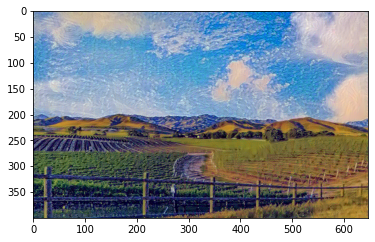

Total loss:  17.408415


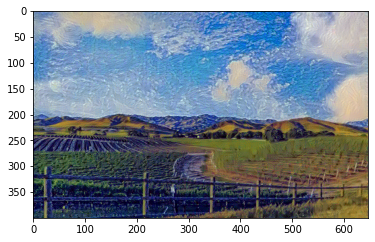

Total loss:  8.044584


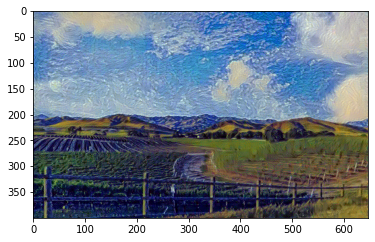

Total loss:  4.276854


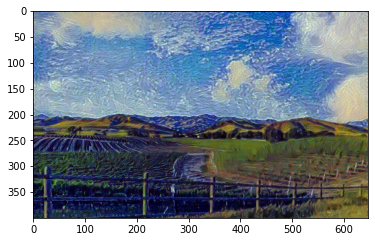

Total loss:  2.5957425


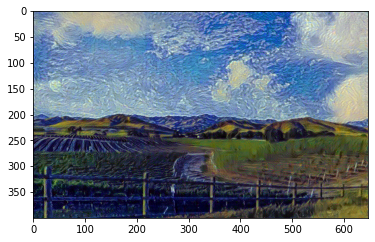

Total loss:  1.7897271


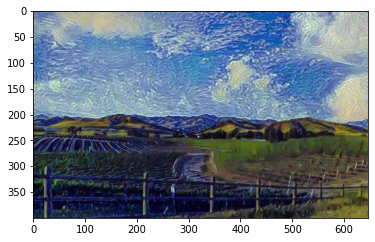

Total loss:  1.3440303


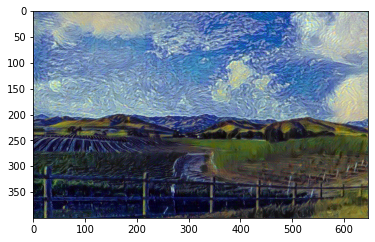

Total loss:  1.0792587


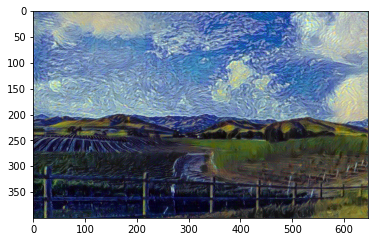

Total loss:  0.9018776


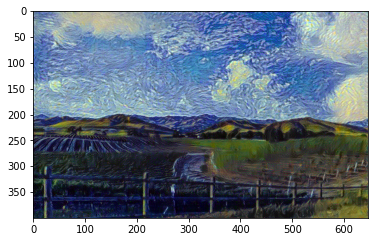

Total loss:  0.7921537


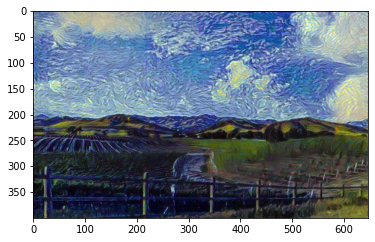

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 训练设置
show_every = 500
steps = 5000

#定义backbone对象
net = ExtractorNet()
for param in net.get_parameters():
    param.requires_grad = False

# 加载训练图片
content = load_image('figs/content.jpg')
style = load_image('figs/style.jpeg', shape=content.shape[-2:])


# 提取backbone中间层特征
content_features = net(content)
style_features = net(style)

# 定义权重
style_weights = [1, 0.75, 0.75, 0.2, 0.2, 0.2]
content_weight = 1
style_weight = 1e9

# 定义目标图像
target_net = TargetNet(content, net)

#定义优化器
opt = nn.Adam(params=target_net.trainable_params(), learning_rate=0.003)

net_with_criterion = MSELossWithCell(target_net)  # 构建损失网络 前向传播
train_net = MyTrainStep(net_with_criterion, opt)     # 构建训练网络 反向传播

for step in range(1, steps+1):
    train_net(content_features, style_features)                  # 执行训练，并更新权重
    loss = net_with_criterion(content_features, style_features)  # 计算损失值
    if step % show_every == 0:        # 显示10轮结果
        print("Total loss: ", loss)
        plt.imshow(im_convert(ms.Tensor(target_net.parameter)))
        plt.show()

## 展示结果


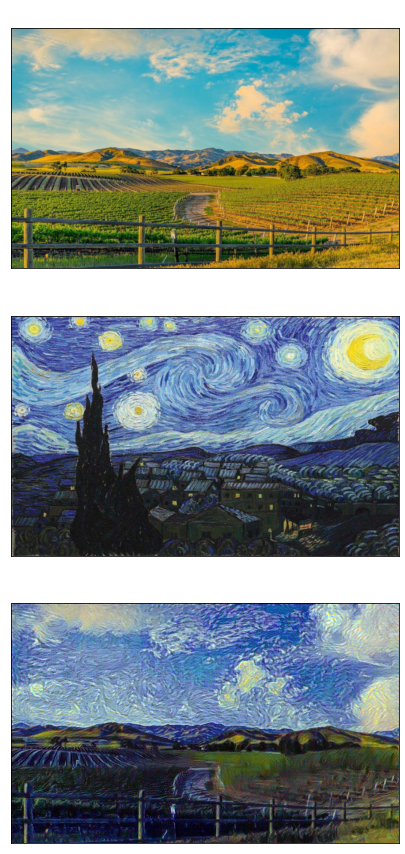

In [16]:
fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=20, color='white')
ax3.imshow(im_convert(style))
ax3.set_title("Style Image", fontsize=20, color='white')
ax2.imshow(im_convert(ms.Tensor(target_net.parameter)))
ax2.set_title("Stylized Target Image", fontsize=20, color='white')
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
plt.show()
# plt.savefig('figs/target.jpg')